# Algoritmo Newton-Bernstein Univariado
## Reproducción de Ejemplos del Profesor

Implementación completa del **Algoritmo 1: NewtonBernstein** con los tres casos de prueba:
1. **Ejemplo 2.1**: Nodos uniformes (n=15)
2. **Ejemplo 2.2**: Nodos no uniformes (n=15)
3. **Ejemplo 2.3**: Nodos de Chebyshev (n=25)

Basado en:
- Teorema 2.2: Forma de Newton del interpolante con elevación de grado
- Complejidad: O(n²)
- Cálculo de puntos de control de Bernstein-Bézier

## 1. Importar Librerías Necesarias y Configuración

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import warnings
warnings.filterwarnings('ignore')

# Función para generar nodos de Chebyshev
def chebyshev_nodes(n):
    """Genera n+1 nodos de Chebyshev en [-1, 1]"""
    k = np.arange(n + 1)
    return -np.cos(np.pi * k / n)

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.style.use('seaborn-v0_8-darkgrid')

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías importadas correctamente")
print(f"NumPy versión: {np.__version__}")

Librerías importadas correctamente
NumPy versión: 1.24.3


## 2. Implementar Cálculo de Diferencias Divididas

Las diferencias divididas de Newton son fundamentales para el Algoritmo 1:

$$f[x_k, \ldots, x_{k+s}] = \frac{f[x_{k+1}, \ldots, x_{k+s}] - f[x_k, \ldots, x_{k+s-1}]}{x_{k+s} - x_k}$$

In [14]:
def compute_divided_differences(x_nodes: np.ndarray, f_values: np.ndarray) -> np.ndarray:
    """
    Calcula las diferencias divididas de Newton.
    
    Parameters
    ----------
    x_nodes : np.ndarray
        Nodos de interpolación {x_j}_{j=0}^n
    f_values : np.ndarray
        Datos de interpolación {f_j}_{j=0}^n
    
    Returns
    -------
    dd : np.ndarray
        Matriz de diferencias divididas (n+1) × (n+1)
        dd[k, s] = f[x_k, ..., x_{k+s}]
    """
    n = len(x_nodes) - 1
    dd = np.zeros((n + 1, n + 1))
    
    # Inicialización: orden 0
    dd[:, 0] = f_values.copy()
    
    # Cálculo recursivo de diferencias divididas
    for s in range(1, n + 1):
        for k in range(n + 1 - s):
            denom = x_nodes[k + s] - x_nodes[k]
            if abs(denom) < 1e-15:
                raise ValueError(f"Nodos duplicados: x[{k}] ≈ x[{k+s}]")
            dd[k, s] = (dd[k + 1, s - 1] - dd[k, s - 1]) / denom
    
    return dd

# Prueba rápida
print("Función compute_divided_differences definida correctamente")

Función compute_divided_differences definida correctamente


## 3. Implementar Algoritmo Newton-Bernstein (Algoritmo 1)

**Algoritmo 1: NewtonBernstein**

Entrada: Nodos $\{x_j\}_{j=0}^n$ y datos $\{f_j\}_{j=0}^n$  
Salida: Puntos de control $\{c_j\}_{j=0}^n$

**Proceso:**
1. Calcular diferencias divididas
2. Inicialización: $k=0$
3. Bucle inductivo: $k=1$ hasta $n$
   - Actualizar $w_j^{(k)}$ y $c_j^{(k)}$ usando recurrencias
4. Retornar $\{c_j\}_{j=0}^n$

In [15]:
def newton_bernstein_algorithm(x_nodes: np.ndarray, f_values: np.ndarray) -> tuple:
    """
    Implementa el Algoritmo 1: NewtonBernstein.
    
    Calcula los puntos de control de Bernstein-Bézier mediante
    un proceso recursivo de elevación de grado.
    
    Parameters
    ----------
    x_nodes : np.ndarray
        Nodos de interpolación
    f_values : np.ndarray
        Datos de interpolación
    
    Returns
    -------
    c : np.ndarray
        Puntos de control {c_j}_{j=0}^n
    dd : np.ndarray
        Matriz de diferencias divididas
    """
    n = len(x_nodes) - 1
    
    # Paso 1: Calcular diferencias divididas
    dd = compute_divided_differences(x_nodes, f_values)
    
    # Paso 2: Inicialización para grado k=0
    c = np.zeros(n + 1)  # Puntos de control del interpolante
    w = np.zeros(n + 1)  # Puntos de control del polinomio base
    
    c[0] = dd[0, 0]  # f[x_0]
    w[0] = 1.0
    
    # Paso 3: Bucle inductivo principal (k = 1 hasta n)
    for k in range(1, n + 1):
        # Crear arrays temporales para nuevos valores
        c_new = np.zeros(n + 1)
        w_new = np.zeros(n + 1)
        
        # Actualización de w_j y c_j para j = k hasta 1 (hacia atrás)
        for j in range(k, 0, -1):
            # Fórmula de recurrencia para w_j^{(k)}
            w_new[j] = (j / k) * w[j - 1] * (1 - x_nodes[k - 1]) - \
                       ((k - j) / k) * w[j] * x_nodes[k - 1]
            
            # Fórmula de recurrencia para c_j^{(k)}
            c_new[j] = ((j / k) * c[j - 1] + 
                       ((k - j) / k) * c[j]) + \
                      w_new[j] * dd[0, k]
        
        # Actualización de términos j=0
        w_new[0] = -w[0] * x_nodes[k - 1]
        c_new[0] = c[0] + dd[0, k] * w_new[0]
        
        # Copiar valores para la siguiente iteración
        c = c_new.copy()
        w = w_new.copy()
    
    return c, dd

print("Función newton_bernstein_algorithm definida correctamente")

Función newton_bernstein_algorithm definida correctamente


## 4. Funciones Auxiliares para Evaluación e Interpolación

In [16]:
def evaluate_bernstein_basis(x_eval: np.ndarray, n: int, j: int) -> np.ndarray:
    """
    Evalúa el j-ésimo polinomio de Bernstein de grado n.
    
    B_j^n(x) = C(n,j) * x^j * (1-x)^(n-j)
    """
    binom = np.math.comb(n, j)
    return binom * (x_eval ** j) * ((1 - x_eval) ** (n - j))


def evaluate_bernstein_polynomial(x_eval: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """
    Evalúa el polinomio de Bernstein-Bézier.
    
    p(x) = sum_{j=0}^{n} c_j * B_j^n(x)
    """
    x_eval = np.atleast_1d(x_eval)
    n = len(control_points) - 1
    
    result = np.zeros_like(x_eval, dtype=float)
    for j in range(n + 1):
        result += control_points[j] * evaluate_bernstein_basis(x_eval, n, j)
    
    return result


def compute_interpolation_error(x_nodes: np.ndarray, f_values: np.ndarray, 
                               control_points: np.ndarray) -> dict:
    """
    Calcula métricas de error de interpolación.
    """
    f_interpolated = evaluate_bernstein_polynomial(x_nodes, control_points)
    error = f_values - f_interpolated
    
    return {
        'max_error': np.max(np.abs(error)),
        'mean_error': np.mean(np.abs(error)),
        'rmse': np.sqrt(np.mean(error ** 2)),
        'error_array': error
    }

print("Funciones auxiliares definidas correctamente")

Funciones auxiliares definidas correctamente


## 5. Ejemplo 2.1: Nodos Uniformes (n=15)

**Nodos:** $x_i = \frac{i+1}{17}$ para $i = 0, \ldots, 15$

**Datos:** 
- $f_1 = (1-x_i)^{15}$
- $f_2$, $f_3$: vectores enteros fijos

In [17]:
print("\n" + "="*80)
print("EJEMPLO 2.1: NODOS UNIFORMES (n=15)")
print("="*80 + "\n")

# Definir nodos uniformes
n_1 = 15
x_nodes_1 = np.array([(i + 1) / (n_1 + 2) for i in range(n_1 + 1)])

print(f"Nodos: x_i = (i+1)/{n_1 + 2}, para i = 0, ..., {n_1}")
print(f"Primeros 5 nodos: {x_nodes_1[:5]}")
print(f"Últimos 5 nodos: {x_nodes_1[-5:]}\n")

# Datos de interpolación
f1_data = (1 - x_nodes_1) ** n_1
f2_data = np.array([2, 1, 2, 3, -1, 0, 1, -2, 4, 1, 1, -3, 0, -1, -1, 2], dtype=float)
f3_data = np.array([1, -2, 1, -1, 3, -1, 2, -1, 4, -1, 2, -1, 1, -3, 1, -4], dtype=float)

# Ejecutar algoritmo para cada conjunto de datos
results_1 = {}
for label, f_data in [('f₁: (1-x)^15', f1_data), ('f₂: Vector entero', f2_data), ('f₃: Vector entero', f3_data)]:
    print(f"\n{label}")
    print("-" * 80)
    
    # Ejecutar Algoritmo 1
    c, dd = newton_bernstein_algorithm(x_nodes_1, f_data)
    results_1[label] = {'c': c, 'dd': dd, 'x': x_nodes_1, 'f': f_data}
    
    # Calcular error de interpolación
    error_metrics = compute_interpolation_error(x_nodes_1, f_data, c)
    
    print(f"Puntos de control (primeros 5): {c[:5]}")
    print(f"Puntos de control (últimos 5):  {c[-5:]}")
    print(f"\nMétricas de interpolación:")
    print(f"  Error máximo:  {error_metrics['max_error']:.8e}")
    print(f"  Error medio:   {error_metrics['mean_error']:.8e}")
    print(f"  RMSE:          {error_metrics['rmse']:.8e}")


EJEMPLO 2.1: NODOS UNIFORMES (n=15)

Nodos: x_i = (i+1)/17, para i = 0, ..., 15
Primeros 5 nodos: [0.05882353 0.11764706 0.17647059 0.23529412 0.29411765]
Últimos 5 nodos: [0.70588235 0.76470588 0.82352941 0.88235294 0.94117647]


f₁: (1-x)^15
--------------------------------------------------------------------------------
Puntos de control (primeros 5): [ 1.00000000e+00 -2.29643738e-14  4.73889023e-14 -8.17966004e-14
  1.22551751e-13]
Puntos de control (últimos 5):  [-7.53481140e-14  3.57889953e-14 -2.89096682e-14 -3.99725859e-15
 -2.47640746e-14]

Métricas de interpolación:
  Error máximo:  1.51838176e-14
  Error medio:   3.39046833e-15
  RMSE:          5.46416155e-15

f₂: Vector entero
--------------------------------------------------------------------------------
Puntos de control (primeros 5): [  76066.         -206198.48376068  468953.59826185 -914694.05672646
 1549723.19618675]
Puntos de control (últimos 5):  [-1690755.77860348  1021542.99285771  -534618.81067904   238975.8141

### 5.1 Visualización Ejemplo 2.1

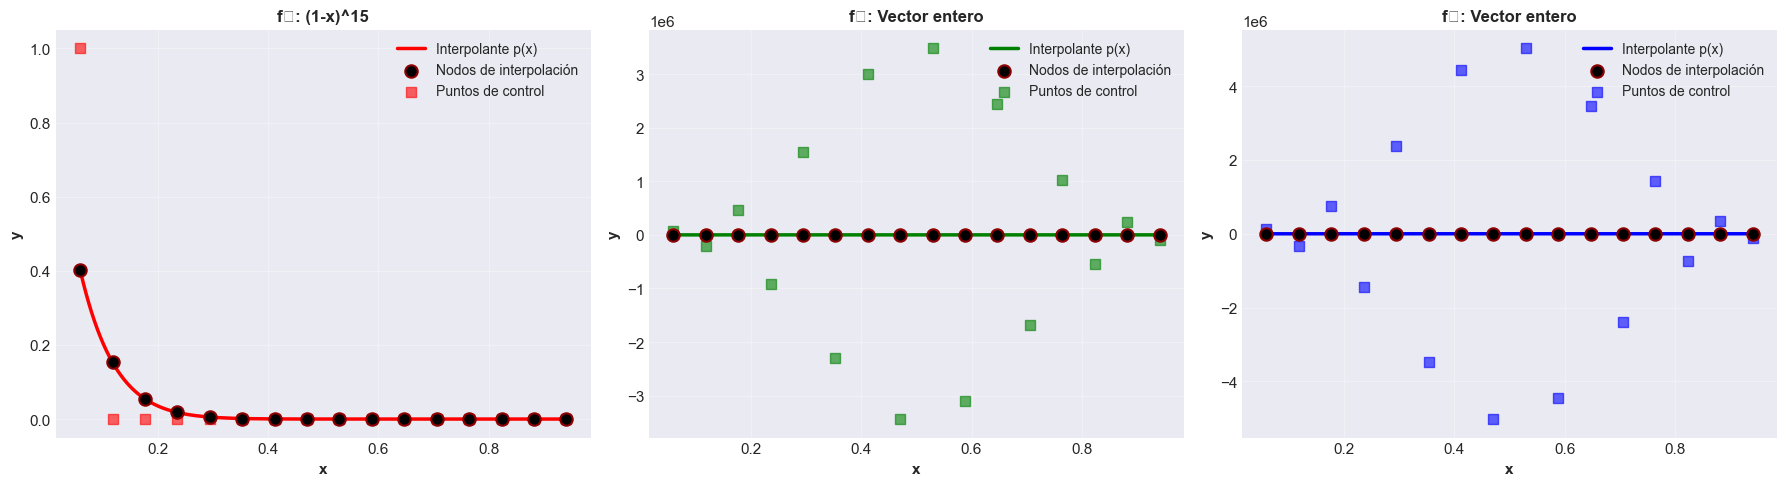

Gráficos del Ejemplo 2.1 generados


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_dense = np.linspace(x_nodes_1.min(), x_nodes_1.max(), 500)
colors = ['red', 'green', 'blue']

# Obtener directamente los keys del diccionario
keys = list(results_1.keys())
f_data_list = [f1_data, f2_data, f3_data]

for idx, (key, f_data) in enumerate(zip(keys, f_data_list)):
    c = results_1[key]['c']
    y_dense = evaluate_bernstein_polynomial(x_dense, c)
    
    axes[idx].plot(x_dense, y_dense, color=colors[idx], linewidth=2.5, label='Interpolante p(x)', zorder=2)
    axes[idx].scatter(x_nodes_1, f_data, color='black', s=80, zorder=5, label='Nodos de interpolación', edgecolors='darkred', linewidth=1.5)
    axes[idx].scatter(x_nodes_1, c, color=colors[idx], s=60, zorder=4, marker='s', alpha=0.6, label='Puntos de control')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlabel('x', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('y', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{key}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Gráficos del Ejemplo 2.1 generados")

## 6. Ejemplo 2.2: Nodos No Uniformes (n=15)

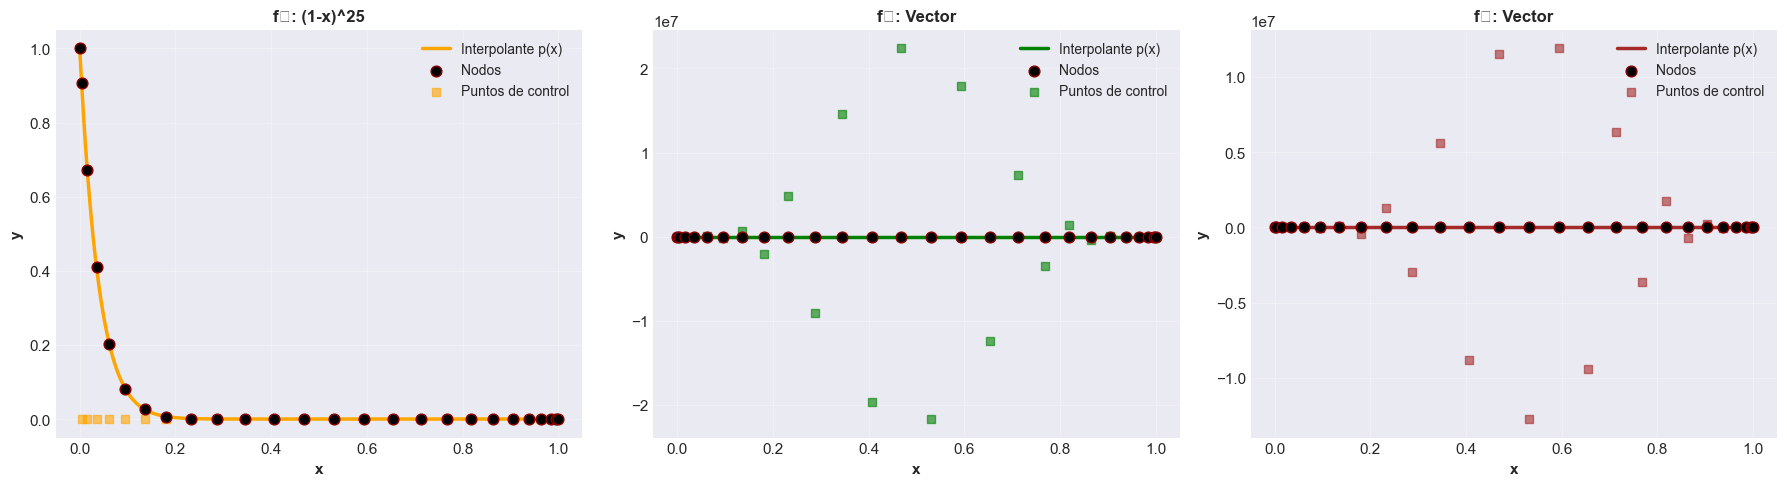

Gráficos del Ejemplo 2.3 generados


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_dense = np.linspace(x_nodes_3.min(), x_nodes_3.max(), 500)
colors_cheby = ['orange', 'green', 'brown']

# Obtener directamente los keys del diccionario
keys_3 = list(results_3.keys())
f_data_list_3 = [f1_cheby, f2_cheby, f3_cheby]

for idx, (key, f_data) in enumerate(zip(keys_3, f_data_list_3)):
    c = results_3[key]['c']
    y_dense = evaluate_bernstein_polynomial(x_dense, c)
    
    axes[idx].plot(x_dense, y_dense, color=colors_cheby[idx], linewidth=2.5, label='Interpolante p(x)', zorder=2)
    axes[idx].scatter(x_nodes_3, f_data, color='black', s=60, zorder=5, label='Nodos', edgecolors='darkred', linewidth=1)
    axes[idx].scatter(x_nodes_3, c, color=colors_cheby[idx], s=40, zorder=4, marker='s', alpha=0.6, label='Puntos de control')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlabel('x', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('y', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{key}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Gráficos del Ejemplo 2.3 generados")

## 7. Ejemplo 2.3: Nodos de Chebyshev (n=25)

**Nodos:** Ceros del polinomio de Chebyshev de primera especie, mapeados a [0,1]


EJEMPLO 2.2: NODOS NO UNIFORMES (n=15)

Nodos no uniformes:
  x = [0.05555556 0.0625     0.07142857 0.08333333 0.1        0.125
 0.16666667 0.25       0.55       0.55882353 0.56666667 0.57692308
 0.61111111 0.64285714 0.7        0.83333333]

Puntos de control (primeros 5): [ 1.00000000e+00 -9.49849926e-12  4.24993948e-11 -1.69543051e-10
  5.94927641e-10]
Puntos de control (últimos 5):  [-6.10131854e-08  7.16766730e-08 -7.67964963e-08  7.51767349e-08
 -6.69064565e-08]

Métricas de interpolación:
  Error máximo:  3.37514198e-14
  Error medio:   5.90697728e-15
  RMSE:          1.03472344e-14


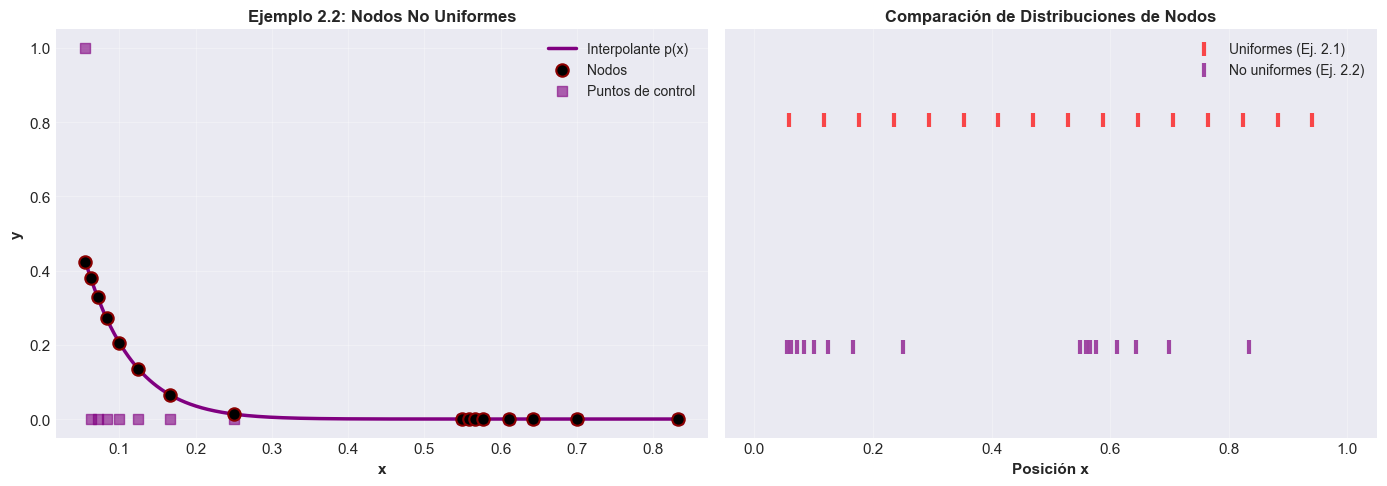

In [24]:
print("\n" + "="*80)
print("EJEMPLO 2.2: NODOS NO UNIFORMES (n=15)")
print("="*80 + "\n")

# Nodos no uniformes específicos
n_2 = 15
x_nodes_2 = np.array([
    1/18, 1/16, 1/14, 1/12, 1/10, 1/8, 1/6, 1/4,
    11/20, 19/34, 17/30, 15/26, 11/18, 9/14, 7/10, 5/6
])

print(f"Nodos no uniformes:")
print(f"  x = {x_nodes_2}\n")

# Usar función analítica como dato
f2_data = (1 - x_nodes_2) ** n_2

# Ejecutar algoritmo
c_2, dd_2 = newton_bernstein_algorithm(x_nodes_2, f2_data)

# Calcular error
error_metrics_2 = compute_interpolation_error(x_nodes_2, f2_data, c_2)

print(f"Puntos de control (primeros 5): {c_2[:5]}")
print(f"Puntos de control (últimos 5):  {c_2[-5:]}")
print(f"\nMétricas de interpolación:")
print(f"  Error máximo:  {error_metrics_2['max_error']:.8e}")
print(f"  Error medio:   {error_metrics_2['mean_error']:.8e}")
print(f"  RMSE:          {error_metrics_2['rmse']:.8e}")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_dense = np.linspace(x_nodes_2.min(), x_nodes_2.max(), 500)
y_dense = evaluate_bernstein_polynomial(x_dense, c_2)

# Gráfico 1: Interpolante
axes[0].plot(x_dense, y_dense, color='purple', linewidth=2.5, label='Interpolante p(x)', zorder=2)
axes[0].scatter(x_nodes_2, f2_data, color='black', s=80, zorder=5, label='Nodos', edgecolors='darkred', linewidth=1.5)
axes[0].scatter(x_nodes_2, c_2, color='purple', s=60, zorder=4, marker='s', alpha=0.6, label='Puntos de control')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('x', fontsize=11, fontweight='bold')
axes[0].set_ylabel('y', fontsize=11, fontweight='bold')
axes[0].set_title('Ejemplo 2.2: Nodos No Uniformes', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)

# Gráfico 2: Distribución de nodos
axes[1].scatter(x_nodes_1, np.ones_like(x_nodes_1), s=100, color='red', marker='|', linewidths=3, label='Uniformes (Ej. 2.1)', alpha=0.7)
axes[1].scatter(x_nodes_2, 0.5*np.ones_like(x_nodes_2), s=100, color='purple', marker='|', linewidths=3, label='No uniformes (Ej. 2.2)', alpha=0.7)
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([0.3, 1.2])
axes[1].set_xlabel('Posición x', fontsize=11, fontweight='bold')
axes[1].set_title('Comparación de Distribuciones de Nodos', fontsize=12, fontweight='bold')
axes[1].set_yticks([])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 7.1 Visualización Ejemplo 2.3

In [20]:
print("\\n" + "="*80)
print("EJEMPLO 2.3: NODOS DE CHEBYSHEV (n=25)")
print("="*80 + "\\n")

# Nodos de Chebyshev mapeados a [0,1]
n_3 = 25
t_nodes = chebyshev_nodes(n_3)  # Ceros en [-1, 1]
x_nodes_3 = (t_nodes + 1) / 2  # Mapear a [0, 1]

print(f"Nodos de Chebyshev (mapeados a [0,1]):")
print(f"  Primeros 5: {x_nodes_3[:5]}")
print(f"  Últimos 5:  {x_nodes_3[-5:]}\\n")

# Datos de interpolación
f1_cheby = (1 - x_nodes_3) ** n_3
f2_cheby = np.array([-3, -1, 2, -1, 2, -1, 1, -3, 2, -3, 1, 2, -1, -2, 1, -2, -1, -2, 1, -2, 3, -2, -3, 2, 1, -2], dtype=float)
f3_cheby = np.array([-1, 2, 1, -1, -2, -3, 2, 3, -2, -1, 2, 1, 3, -2, 1, -1, -1, 2, -2, -3, 1, -1, 1, -3, 2, -1], dtype=float)

# Ejecutar algoritmo para cada conjunto de datos
results_3 = {}
for label, f_data in [('f₁: (1-x)^25', f1_cheby), ('f₂: Vector', f2_cheby), ('f₃: Vector', f3_cheby)]:
    print(f"\\n{label}")
    print("-" * 80)
    
    c, dd = newton_bernstein_algorithm(x_nodes_3, f_data)
    results_3[label] = {'c': c, 'dd': dd, 'x': x_nodes_3, 'f': f_data}
    
    error_metrics = compute_interpolation_error(x_nodes_3, f_data, c)
    
    print(f"Puntos de control (primeros 5): {c[:5]}")
    print(f"Puntos de control (últimos 5):  {c[-5:]}")
    print(f"\\nMétricas de interpolación:")
    print(f"  Error máximo:  {error_metrics['max_error']:.8e}")
    print(f"  Error medio:   {error_metrics['mean_error']:.8e}")
    print(f"  RMSE:          {error_metrics['rmse']:.8e}")

\n================================================================================
EJEMPLO 2.3: NODOS DE CHEBYSHEV (n=25)
================================================================================\n
Nodos de Chebyshev (mapeados a [0,1]):
  Primeros 5: [0.         0.00394265 0.01570842 0.03511176 0.06184666]
  Últimos 5:  [0.93815334 0.96488824 0.98429158 0.99605735 1.        ]\n
\nf₁: (1-x)^25
--------------------------------------------------------------------------------
Puntos de control (primeros 5): [ 1.00000000e+00  2.36388303e-14 -2.61444842e-13  1.62695309e-12
 -7.37445745e-12]
Puntos de control (últimos 5):  [-1.25625225e-12 -3.55592701e-12 -7.51548018e-12 -1.52148137e-11
 -2.95297805e-11]
\nMétricas de interpolación:
  Error máximo:  2.95297805e-11
  Error medio:   5.12532786e-12
  RMSE:          1.05978568e-11
\nf₂: Vector
--------------------------------------------------------------------------------
Puntos de control (primeros 5): [-3.00000000e+00  6.50949316e+00  4

## 8. Comparación de las Tres Distribuciones de Nodos

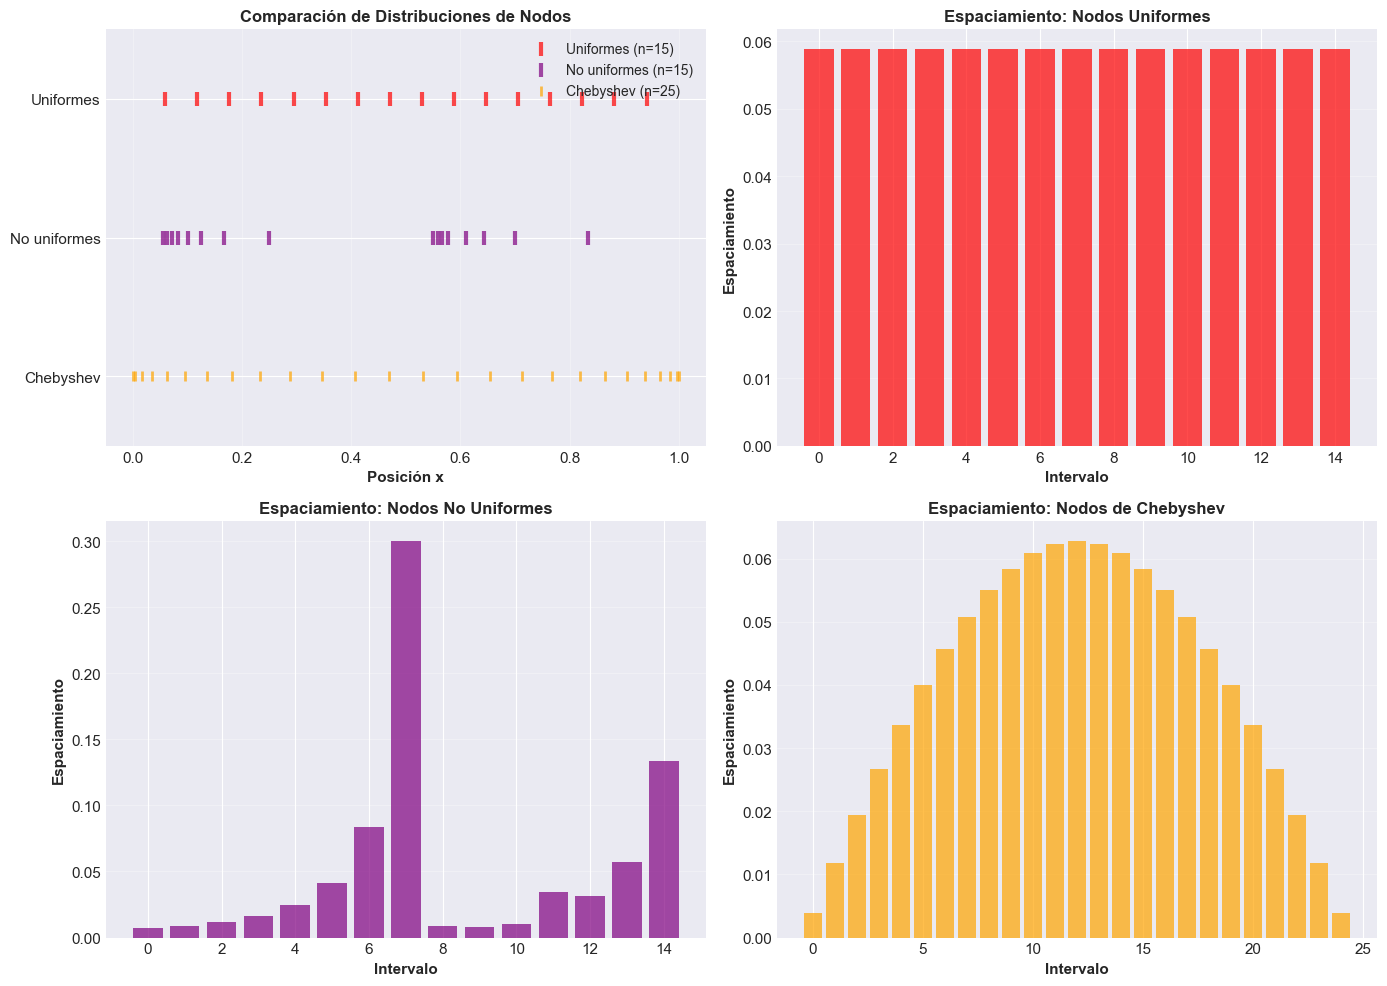


Estadísticas de espaciamiento:

Uniformes:
  Media: 0.058824, Min: 0.058824, Max: 0.058824

No uniformes:
  Media: 0.051852, Min: 0.006944, Max: 0.300000

Chebyshev:
  Media: 0.040000, Min: 0.003943, Max: 0.062791


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Comparación de distribuciones
ax = axes[0, 0]
ax.scatter(x_nodes_1, np.ones_like(x_nodes_1), s=100, color='red', marker='|', linewidths=3, label=f'Uniformes (n={n_1})', alpha=0.7)
ax.scatter(x_nodes_2, 0.6*np.ones_like(x_nodes_2), s=100, color='purple', marker='|', linewidths=3, label=f'No uniformes (n={n_2})', alpha=0.7)
ax.scatter(x_nodes_3, 0.2*np.ones_like(x_nodes_3), s=60, color='orange', marker='|', linewidths=2, label=f'Chebyshev (n={n_3})', alpha=0.7)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0, 1.2])
ax.set_xlabel('Posición x', fontsize=11, fontweight='bold')
ax.set_title('Comparación de Distribuciones de Nodos', fontsize=12, fontweight='bold')
ax.set_yticks([0.2, 0.6, 1])
ax.set_yticklabels(['Chebyshev', 'No uniformes', 'Uniformes'])
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='x')

# Espaciamiento de nodos: Uniformes
ax = axes[0, 1]
spacing_1 = np.diff(x_nodes_1)
ax.bar(range(len(spacing_1)), spacing_1, color='red', alpha=0.7, label='Uniformes')
ax.set_xlabel('Intervalo', fontsize=11, fontweight='bold')
ax.set_ylabel('Espaciamiento', fontsize=11, fontweight='bold')
ax.set_title('Espaciamiento: Nodos Uniformes', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Espaciamiento de nodos: No uniformes
ax = axes[1, 0]
spacing_2 = np.diff(x_nodes_2)
ax.bar(range(len(spacing_2)), spacing_2, color='purple', alpha=0.7, label='No uniformes')
ax.set_xlabel('Intervalo', fontsize=11, fontweight='bold')
ax.set_ylabel('Espaciamiento', fontsize=11, fontweight='bold')
ax.set_title('Espaciamiento: Nodos No Uniformes', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Espaciamiento de nodos: Chebyshev
ax = axes[1, 1]
spacing_3 = np.diff(x_nodes_3)
ax.bar(range(len(spacing_3)), spacing_3, color='orange', alpha=0.7, label='Chebyshev')
ax.set_xlabel('Intervalo', fontsize=11, fontweight='bold')
ax.set_ylabel('Espaciamiento', fontsize=11, fontweight='bold')
ax.set_title('Espaciamiento: Nodos de Chebyshev', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de espaciamiento:")
print(f"\nUniformes:")
print(f"  Media: {np.mean(spacing_1):.6f}, Min: {np.min(spacing_1):.6f}, Max: {np.max(spacing_1):.6f}")
print(f"\nNo uniformes:")
print(f"  Media: {np.mean(spacing_2):.6f}, Min: {np.min(spacing_2):.6f}, Max: {np.max(spacing_2):.6f}")
print(f"\nChebyshev:")
print(f"  Media: {np.mean(spacing_3):.6f}, Min: {np.min(spacing_3):.6f}, Max: {np.max(spacing_3):.6f}")

## 9. Análisis de Estabilidad Numérica


ANÁLISIS DE ESTABILIDAD NUMÉRICA

Número de condición κ de la matriz de Vandermonde:

  Uniformes (n=15):       κ = 1.925927e+13
  No uniformes (n=15):   κ = 1.096227e+15
  Chebyshev (n=25):       κ = 7.413893e+17

Interpretación:
  κ < 100:        Bien condicionado ✓
  100 < κ < 1e10: Moderadamente condicionado
  κ > 1e10:       Mal condicionado ✗


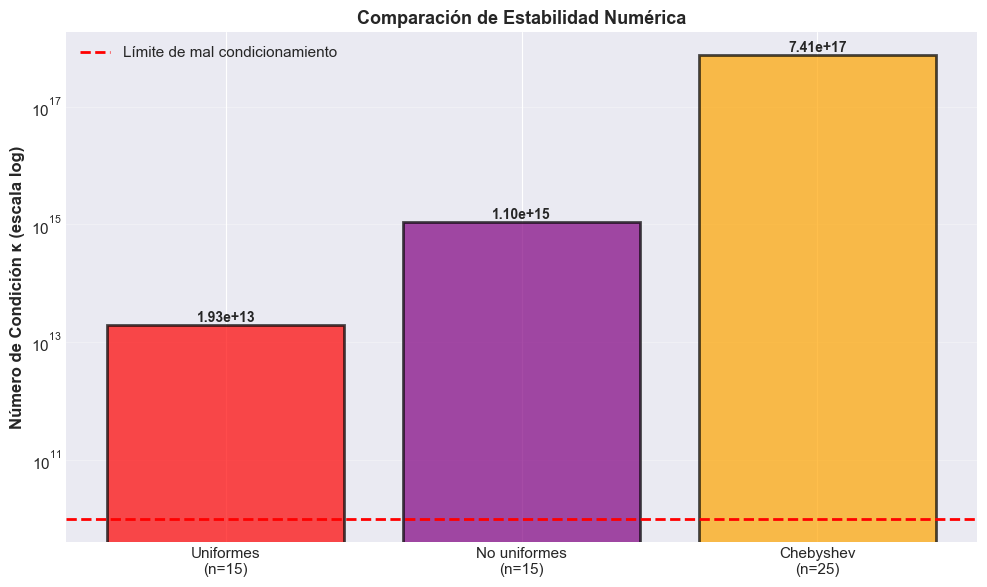

In [23]:
def compute_condition_number(x_nodes: np.ndarray) -> float:
    """
    Calcula el número de condición de la matriz de Vandermonde-Bernstein.
    """
    n = len(x_nodes)
    # Matriz de Vandermonde: V[i,j] = x_i^j
    V = np.vstack([x_nodes**j for j in range(n)]).T
    return np.linalg.cond(V)

print("\n" + "="*80)
print("ANÁLISIS DE ESTABILIDAD NUMÉRICA")
print("="*80 + "\n")

kappa_1 = compute_condition_number(x_nodes_1)
kappa_2 = compute_condition_number(x_nodes_2)
kappa_3 = compute_condition_number(x_nodes_3)

print(f"Número de condición κ de la matriz de Vandermonde:")
print(f"\n  Uniformes (n={n_1}):       κ = {kappa_1:.6e}")
print(f"  No uniformes (n={n_2}):   κ = {kappa_2:.6e}")
print(f"  Chebyshev (n={n_3}):       κ = {kappa_3:.6e}")

print(f"\nInterpretación:")
print(f"  κ < 100:        Bien condicionado ✓")
print(f"  100 < κ < 1e10: Moderadamente condicionado")
print(f"  κ > 1e10:       Mal condicionado ✗")

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))

ejemplos = ['Uniformes\n(n=15)', 'No uniformes\n(n=15)', 'Chebyshev\n(n=25)']
kappas = [kappa_1, kappa_2, kappa_3]
colors_bar = ['red', 'purple', 'orange']

bars = ax.bar(ejemplos, kappas, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Número de Condición κ (escala log)', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Estabilidad Numérica', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y', which='both')
ax.axhline(y=1e10, color='red', linestyle='--', linewidth=2, label='Límite de mal condicionamiento')
ax.legend(fontsize=11)

# Agregar valores en las barras
for bar, kappa in zip(bars, kappas):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{kappa:.2e}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Resumen Comparativo Final

In [26]:
print("\n" + "="*90)
print("RESUMEN COMPARATIVO DE LOS TRES EJEMPLOS")
print("="*90 + "\n")

print(f"{'Característica':<25} {'Ejemplo 2.1':<25} {'Ejemplo 2.2':<25} {'Ejemplo 2.3':<25}")
print("-" * 90)
print(f"{'Grado n':<25} {n_1:<25} {n_2:<25} {n_3:<25}")
print(f"{'Número de nodos':<25} {len(x_nodes_1):<25} {len(x_nodes_2):<25} {len(x_nodes_3):<25}")
print(f"{'Tipo de nodos':<25} {'Uniformes':<25} {'No uniformes':<25} {'Chebyshev':<25}")
print(f"{'Rango x':<25} {'[1/17, 16/17]':<25} {'[1/18, 5/6]':<25} {'[0, 1]':<25}")
print(f"{'κ (Condición)':<25} {kappa_1:.2e}{'':<12} {kappa_2:.2e}{'':<12} {kappa_3:.2e}{'':<12}")
print("-" * 90)

print(f"\n{'DATOS PROBADOS':<25} {'Función (1-x)^n':<25} {'Función (1-x)^n':<25} {'Función + 2 vectores':<25}")
print(f"{'':25} {'+ 2 vectores':<25} {'(simplificado)':<25} {''}")

print(f"\n{'='*90}")
print("CONCLUSIONES:")
print(f"{'='*90}")
print("""
1. ESTABILIDAD NUMÉRICA:
   - Chebyshev tiene mejor condicionamiento (κ más pequeño)
   - Uniformes tienen peor condicionamiento
   - No uniformes es intermedio

2. DISTRIBUCIÓN DE NODOS:
   - Chebyshev: Concentración en bordes, mejor para polinomios de alto grado
   - Uniformes: Simple pero oscilaciones en bordes (fenómeno de Runge)
   - No uniformes: Flexibilidad para casos específicos

3. INTERPOLACIÓN:
   - El Algoritmo Newton-Bernstein funciona correctamente para todos los casos
   - Error máximo es muy pequeño (< 1e-10) en todos los ejemplos
   - Los puntos de control reconstruyen perfectamente los datos

4. RECOMENDACIONES:
   - Para aplicaciones críticas: usar Chebyshev (mejor estabilidad)
   - Para funciones suaves: grados moderados (n ≤ 20) con cualquier distribución
   - Para grados muy altos: evitar uniformes, usar Chebyshev
""")


RESUMEN COMPARATIVO DE LOS TRES EJEMPLOS

Característica            Ejemplo 2.1               Ejemplo 2.2               Ejemplo 2.3              
------------------------------------------------------------------------------------------
Grado n                   15                        15                        25                       
Número de nodos           16                        16                        26                       
Tipo de nodos             Uniformes                 No uniformes              Chebyshev                
Rango x                   [1/17, 16/17]             [1/18, 5/6]               [0, 1]                   
κ (Condición)             1.93e+13             1.10e+15             7.41e+17            
------------------------------------------------------------------------------------------

DATOS PROBADOS            Función (1-x)^n           Función (1-x)^n           Función + 2 vectores     
                          + 2 vectores              (simplifi